<a href="https://colab.research.google.com/github/zergswim/GAN/blob/main/Chapter_8_CGAN(edited).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8장: CGAN

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/gans-in-action/blob/master/chapter-8/Chapter_8_CGAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                                     Embedding, Flatten, Input, Multiply, Reshape)
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)
z_dim = 100
num_classes = 10

## 생성자

In [3]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))
    return model

def build_cgan_generator(z_dim):
    z = Input(shape=(z_dim, ))
    label = Input(shape=(1, ), dtype='int32')
    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)
    label_embedding = Flatten()(label_embedding)
    joined_representation = Multiply()([z, label_embedding])
    generator = build_generator(z_dim)
    conditioned_img = generator(joined_representation)
    return Model([z, label], conditioned_img)

## 판별자

In [4]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(img_shape[0], img_shape[1], img_shape[2] + 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

def build_cgan_discriminator(img_shape):
    img = Input(shape=img_shape)
    label = Input(shape=(1, ), dtype='int32')
    label_embedding = Embedding(num_classes, np.prod(img_shape), input_length=1)(label)
    label_embedding = Flatten()(label_embedding)
    label_embedding = Reshape(img_shape)(label_embedding)
    concatenated = Concatenate(axis=-1)([img, label_embedding])
    discriminator = build_discriminator(img_shape)
    classification = discriminator(concatenated)
    return Model([img, label], classification)


## 모델 만들기

In [5]:
# def build_cgan(generator, discriminator):

#     # 랜덤 잡음 벡터 z
#     z = Input(shape=(z_dim, ))

#     # 이미지 레이블
#     label = Input(shape=(1, ))

#     # 레이블에 맞는 이미지 생성하기
#     img = generator([z, label])

#     classification = discriminator([img, label])

#     # 생성자 -> 판별자 연결 모델 
#     # G([z, label]) = x* 
#     # D(x*) = 분류
#     model = Model([z, label], classification)

#     return model

In [6]:
# 판별자 만들고 컴파일하기
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

# 생성자 만들기
import tensorflow as tf
generator = build_cgan_generator(z_dim)
optimizer_g = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean()

@tf.function
def train_step(z, labels):
    with tf.GradientTape() as tape:
        #z = Input(shape=(z_dim, ))
        #label = Input(shape=(1, ))      
        gen_imgs = generator([z, labels])
        pred = discriminator([gen_imgs, labels]) # or discriminator_supervised?
        loss = tf.keras.losses.binary_crossentropy(labels, pred)
    gradients = tape.gradient(loss, generator.trainable_variables)
    optimizer_g.apply_gradients(zip(gradients, generator.trainable_variables))

    train_loss(loss)
    g_loss = train_loss.result()
    
    return gen_imgs, g_loss

generator.summary()
discriminator.summary()

# generator = build_cgan_generator(z_dim)

# # 생성자를 훈련하는 동안 판별자 모델 파라미터를 고정하기
# discriminator.trainable = False

# # 생성자를 훈련하기 위해 고정된 판별자로 CGAN 모델 만들고 컴파일하기
# cgan = build_cgan(generator, discriminator)
# cgan.compile(loss='binary_crossentropy', optimizer=Adam())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       1000        ['input_4[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 flatten_2 (Flatten)            (None, 100)          0           ['embedding_1[0][0]']            
                                                                                            

## 훈련

In [7]:
accuracies = []
losses = []

def train(iterations, batch_size, sample_interval):
    (X_train, y_train), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        z = np.random.normal(0, 1, (batch_size, z_dim))
        # gen_imgs = generator.predict([z, labels])

        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        gen_imgs, g_loss = train_step(z, labels)

        # 판별자를 훈련합니다.
        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  생성자를 훈련합니다.
        # ---------------------

        # 잡음 벡터의 배치를 생성합니다.
        #z = np.random.normal(0, 1, (batch_size, z_dim))

        # 랜덤한 레이블의 배치를 얻습니다.
        # labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        # 생성자를 훈련합니다.
        # g_loss = cgan.train_on_batch([z, labels], real)

        if (iteration + 1) % sample_interval == 0:
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))
            losses.append((d_loss[0], g_loss))
            accuracies.append(100 * d_loss[1])
            sample_images()

In [8]:
def sample_images(image_grid_rows=2, image_grid_columns=5):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    labels = np.arange(0, 10).reshape(-1, 1)
    gen_imgs = generator.predict([z, labels])
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % labels[cnt])
            cnt += 1
    
    plt.show()

# 모델을 훈련하고 훈련 과정 확인하기

1000 [D loss: 0.641773, acc.: 85.94%] [G loss: 0.189986]


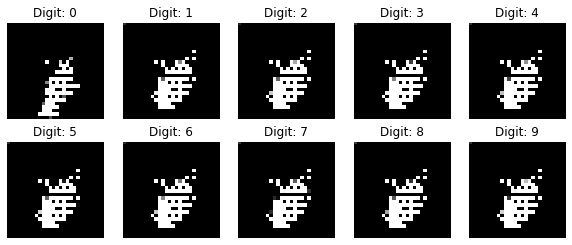

2000 [D loss: 0.151690, acc.: 100.00%] [G loss: 1.309891]


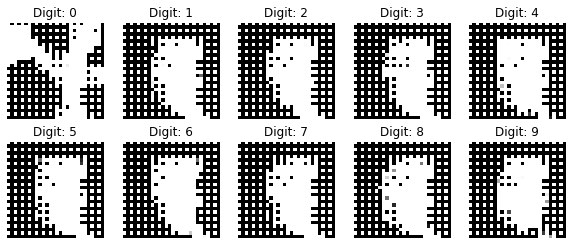

3000 [D loss: 0.003292, acc.: 100.00%] [G loss: 6.809189]


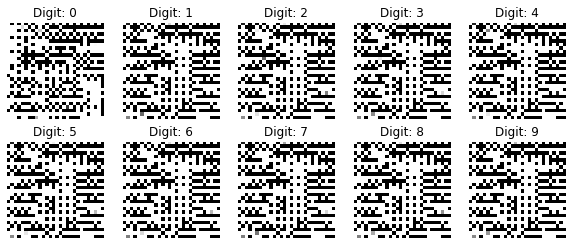

4000 [D loss: 0.000520, acc.: 100.00%] [G loss: 12.293067]


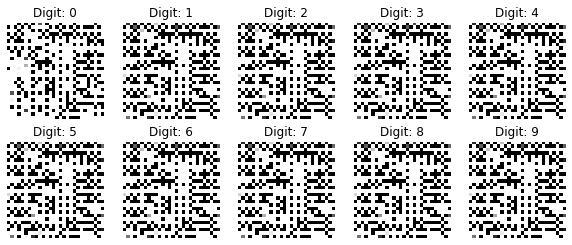

5000 [D loss: 0.000122, acc.: 100.00%] [G loss: 17.078009]


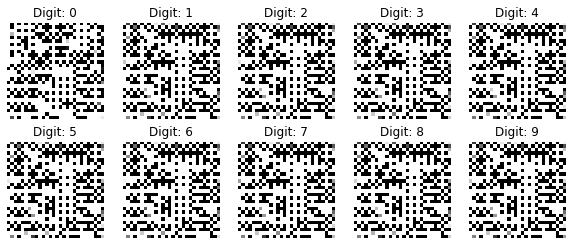

6000 [D loss: 0.000032, acc.: 100.00%] [G loss: 21.251486]


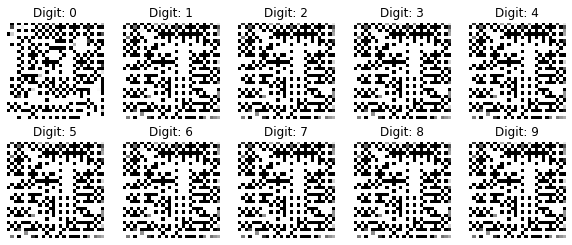

7000 [D loss: 0.596831, acc.: 51.56%] [G loss: 23.853172]


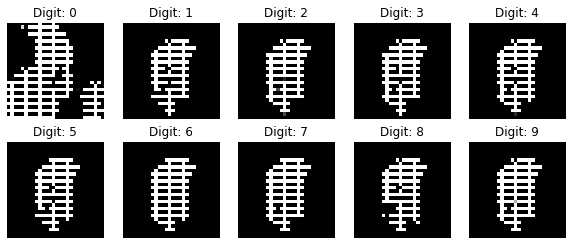

8000 [D loss: 0.556147, acc.: 82.81%] [G loss: 20.977425]


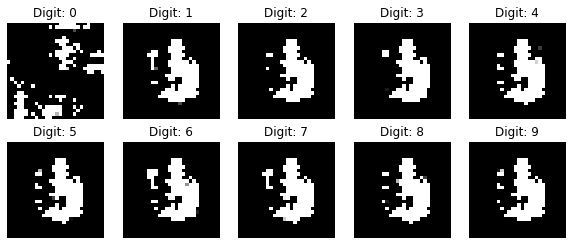

9000 [D loss: 0.386532, acc.: 100.00%] [G loss: 18.812248]


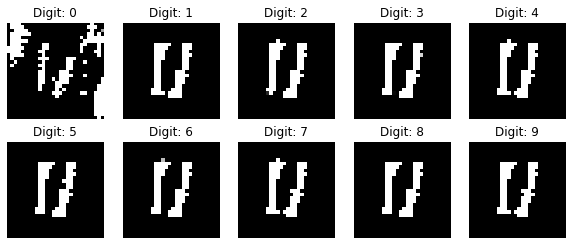

10000 [D loss: 0.613085, acc.: 56.25%] [G loss: 17.058506]


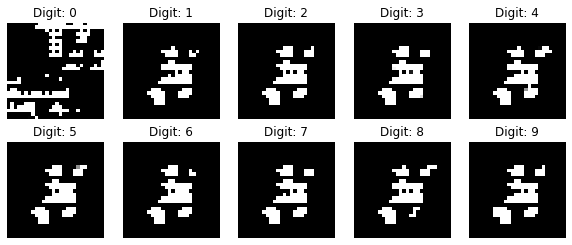

11000 [D loss: 0.499622, acc.: 87.50%] [G loss: 15.653879]


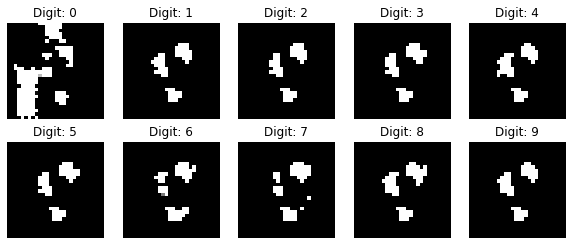

12000 [D loss: 0.392100, acc.: 92.19%] [G loss: 14.536101]


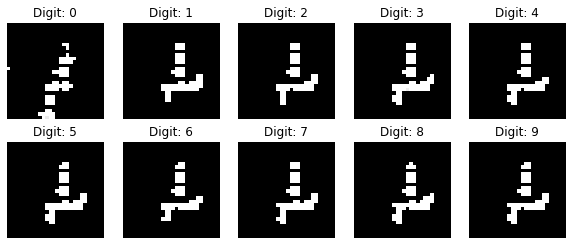

13000 [D loss: 0.499841, acc.: 95.31%] [G loss: 13.673793]


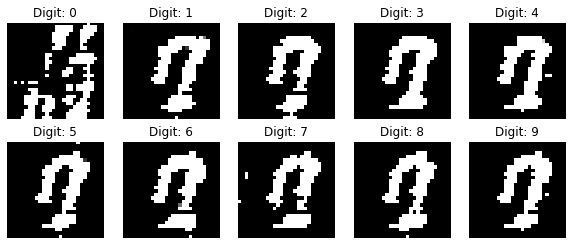

14000 [D loss: 0.474547, acc.: 87.50%] [G loss: 12.916755]


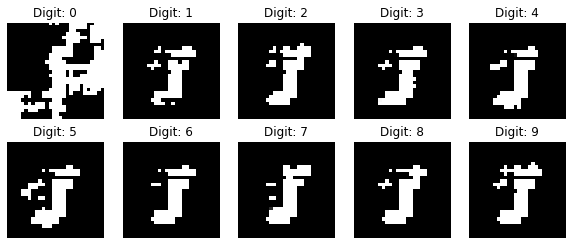

15000 [D loss: 0.324691, acc.: 95.31%] [G loss: 12.295760]


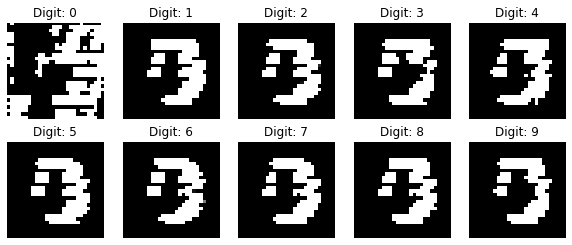

16000 [D loss: 0.387552, acc.: 98.44%] [G loss: 11.846272]


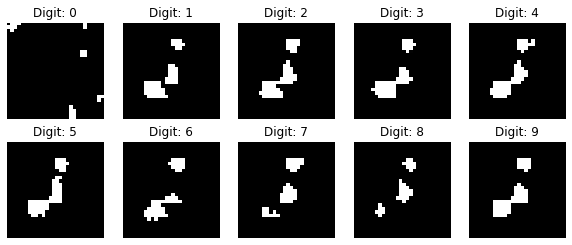

17000 [D loss: 0.087627, acc.: 100.00%] [G loss: 11.514059]


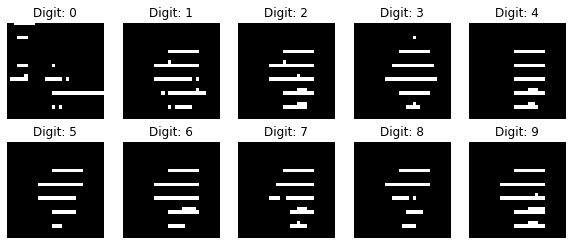

18000 [D loss: 0.151432, acc.: 100.00%] [G loss: 11.574058]


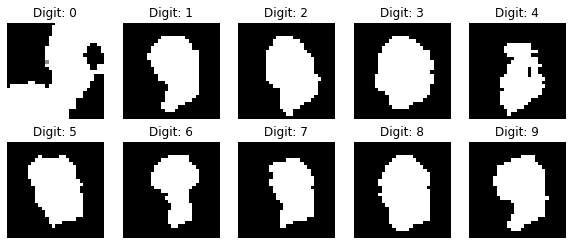

19000 [D loss: 0.113701, acc.: 100.00%] [G loss: 11.365358]


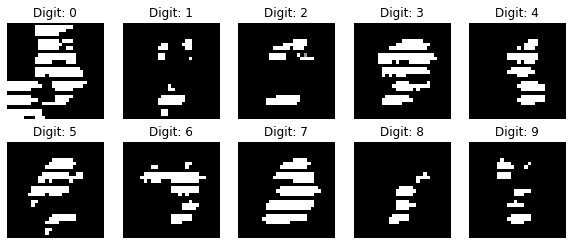

20000 [D loss: 0.170665, acc.: 100.00%] [G loss: 11.344275]


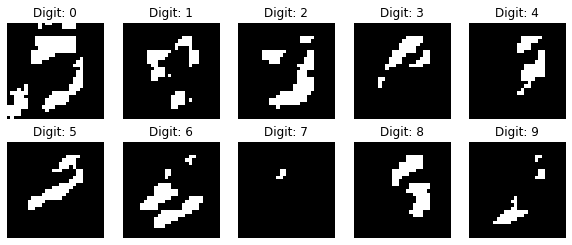

In [9]:
# 하이퍼파라미터를 설정합니다.
iterations = 20000
batch_size = 32
sample_interval = 1000

# 지정된 반복 횟수 동안 CGAN을 훈련합니다.
train(iterations, batch_size, sample_interval)

# 훈련된 CGAN 모델의 출력

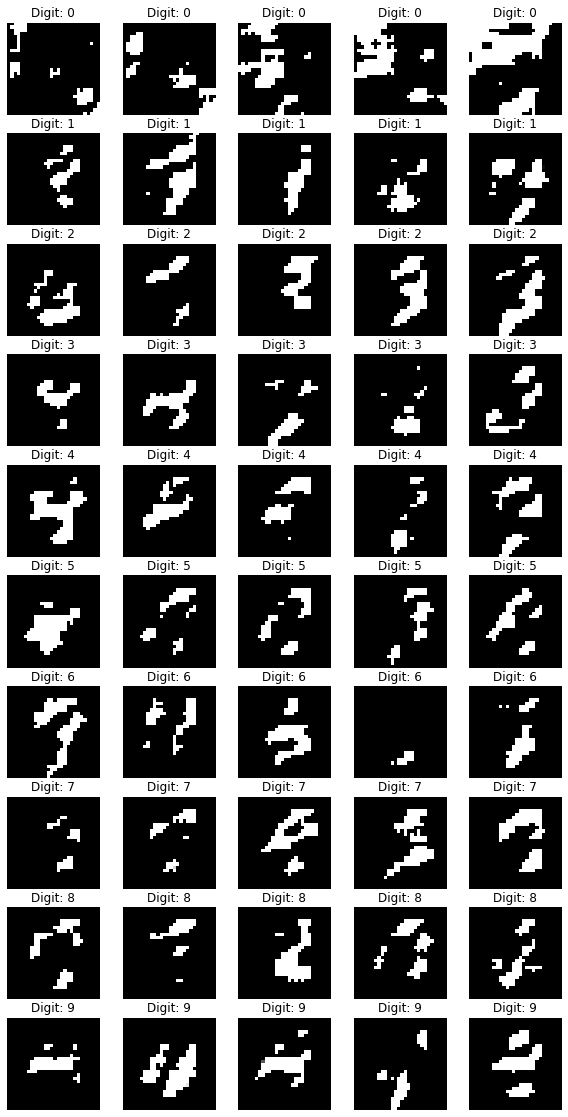

In [10]:
# 그리드 차원을 설정합니다.
image_grid_rows = 10
image_grid_columns = 5

# 랜덤한 잡음을 샘플링합니다.
z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

# 생성할 이미지 레이블을 5개씩 준비합니다.
labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
labels_to_generate = labels_to_generate.flatten().reshape(-1, 1)

# 랜덤한 잡음에서 이미지를 생성합니다.
gen_imgs = generator.predict([z, labels_to_generate])

# 이미지 픽셀 값을 [0, 1] 사이로 스케일을 변환합니다.
gen_imgs = 0.5 * gen_imgs + 0.5

# 이미지 그리드를 설정합니다.
fig, axs = plt.subplots(image_grid_rows,
                        image_grid_columns,
                        figsize=(10, 20),
                        sharey=True,
                        sharex=True)

cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # 이미지 그리드를 출력합니다.
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title("Digit: %d" % labels_to_generate[cnt])  ## NEW
        cnt += 1